In [84]:
from pathlib import Path
import os
import pickle
import numpy as np
from scipy import signal, stats
from matplotlib import pyplot as plt

def iter_pickle(path:Path):
    swds = [pickle.load(open(path/a, 'rb')) for a in  os.listdir(path)]
    swds[0][0].plot(scalings={'eeg':1e-3})
    return swds

def welch_spectrum_all_rats(swds:list, nperseg:int=256, noverlap=200, max_freq:float=30, normalize=True):
    x = None
    welch_total = []
    for rat in swds:
        welch_single_animal = []
        for swd in rat:
            if swd._data.shape[1] < nperseg:
                print (f'dropped swd: length {swd._data.shape[1]} samples is less than welch length {nperseg}')
            else:
                w = signal.welch(swd._data, fs=swd.info['sfreq'], 
                    nperseg=nperseg, noverlap=noverlap, detrend=False)
                x = w[0]
                w = w[1]
                welch_single_animal.append(w)

        cutoff = sum(x <= max_freq)
        welch_single_animal = np.array(welch_single_animal)
        welch_single_animal = np.average(welch_single_animal, axis=0).ravel()
        if normalize:
            welch_single_animal/=np.max(welch_single_animal)
        welch_total.append(welch_single_animal)
    plt.show()
    

    welch_total = np.array(welch_total)[:,:cutoff]
    x = x[:cutoff]
    return x, welch_total

def plot_conditions(spectrums:dict):
    for condition in spectrums['spectrums'].items():
        upper = np.quantile(condition[1], 0.75, axis=0)
        lower = np.quantile(condition[1], 0.25, axis=0)

        avg = np.median(condition[1], axis=0)
        plt.plot(spectrums['x'], avg, label=condition[0])

        plt.fill_between(spectrums['x'], avg-lower, avg+upper, alpha=0.2)
    if 'significance' in list(spectrums.keys()):
        for a in spectrums['significance']:
            plt.axvline(x[a], color='grey', alpha=0.5)
    plt.legend()
    plt.show()

def statistics_nonparametric(spectrums:dict, correction=True):
    cc = [condition[1] for condition in spectrums['spectrums'].items()] # only two
    aaa = [(cc[0][:,a], cc[1][:,a]) for a in range(cc[0].shape[1])]
    mw = [stats.ttest_ind(cc[0][:,a], cc[1][:,a]) for a in range(cc[0].shape[1])]
    p = np.array([a[1] for a in mw])
    if correction:
        p*=cc[0].shape[1]
    significant_values = (np.where(p<0.05))[0]
    if not significant_values.shape[0]:
        print ('no signifncant values found')
    return significant_values


In [85]:
data_path = Path(r'C:\Data\kenul\processed\volkova 220220')

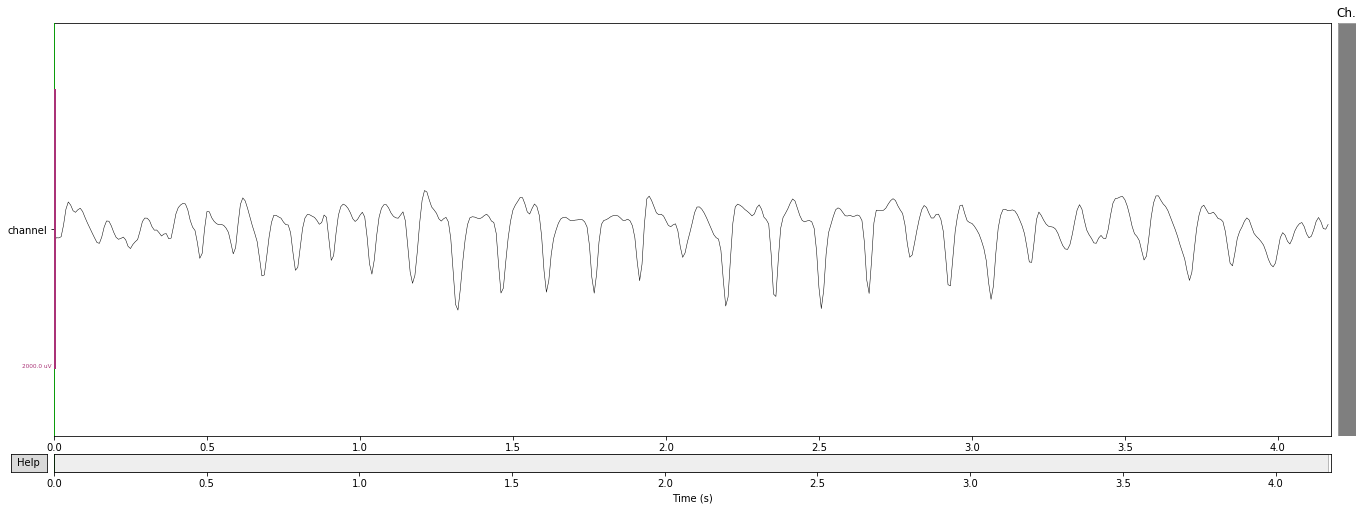

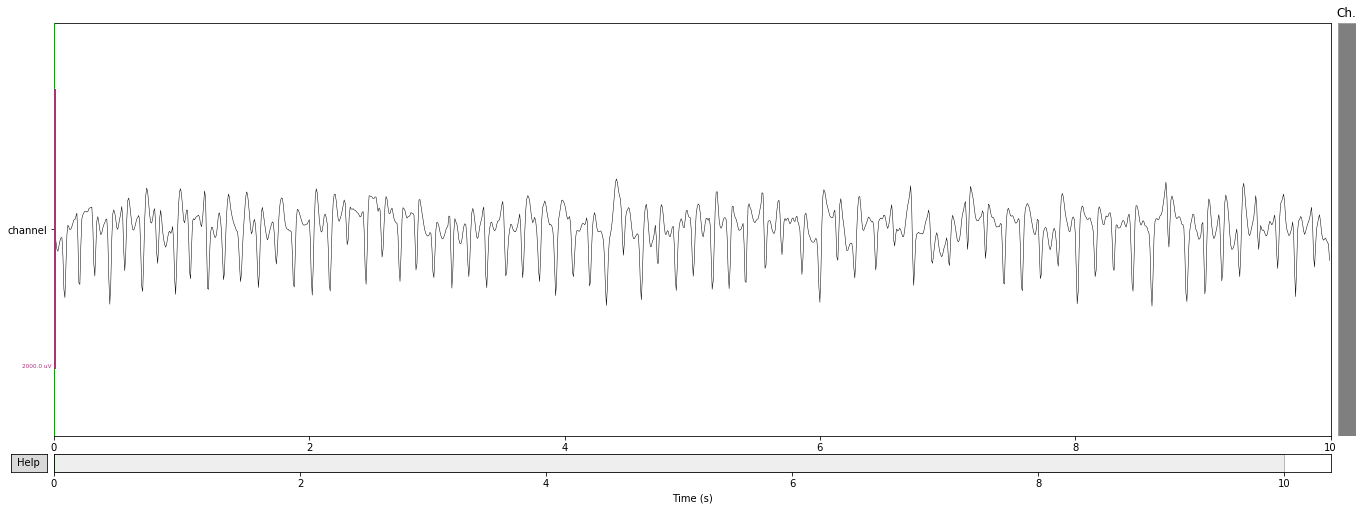

no signifncant values found


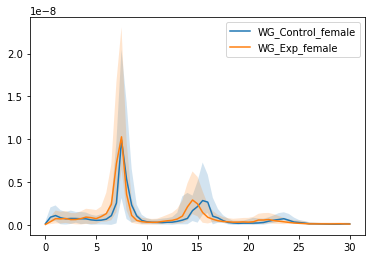

In [86]:
control_name = 'WG_Control_female'
exp_name = 'WG_Exp_female'

x, welch_control_f=welch_spectrum_all_rats(iter_pickle(data_path/control_name), normalize=False)
x, welch_exp_f=welch_spectrum_all_rats(iter_pickle(data_path/exp_name), normalize=False)

spectrums = {'x':x, 'spectrums':{control_name:welch_control_f, exp_name:welch_exp_f}}
spectrums['significance'] = statistics_nonparametric(spectrums, correction=True)
plot_conditions(spectrums)

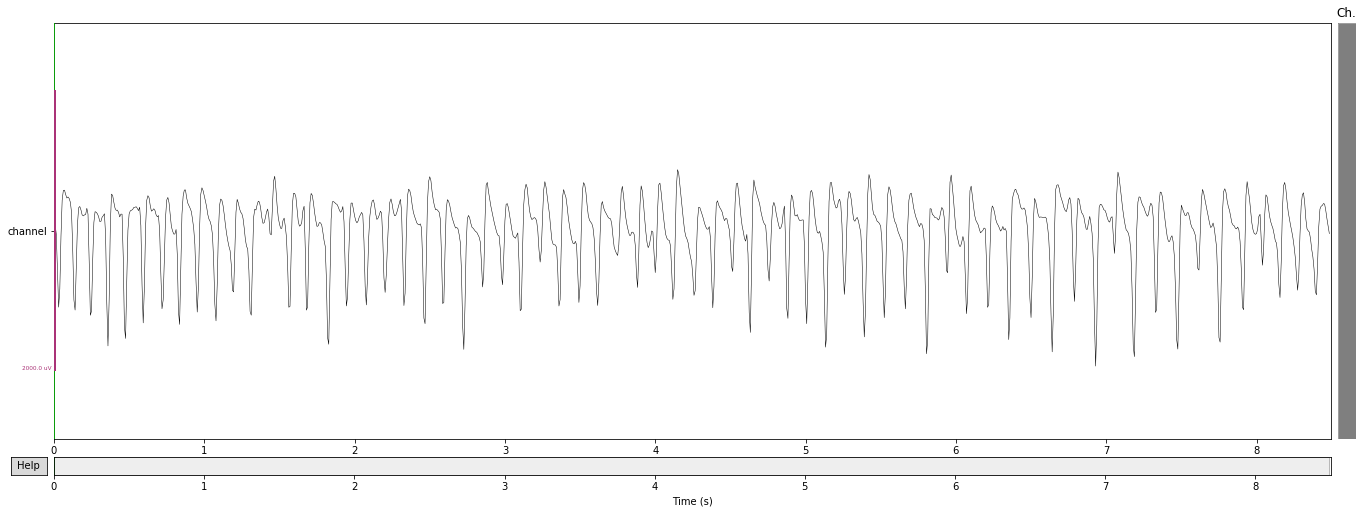

dropped swd: length 25 samples is less than welch length 256


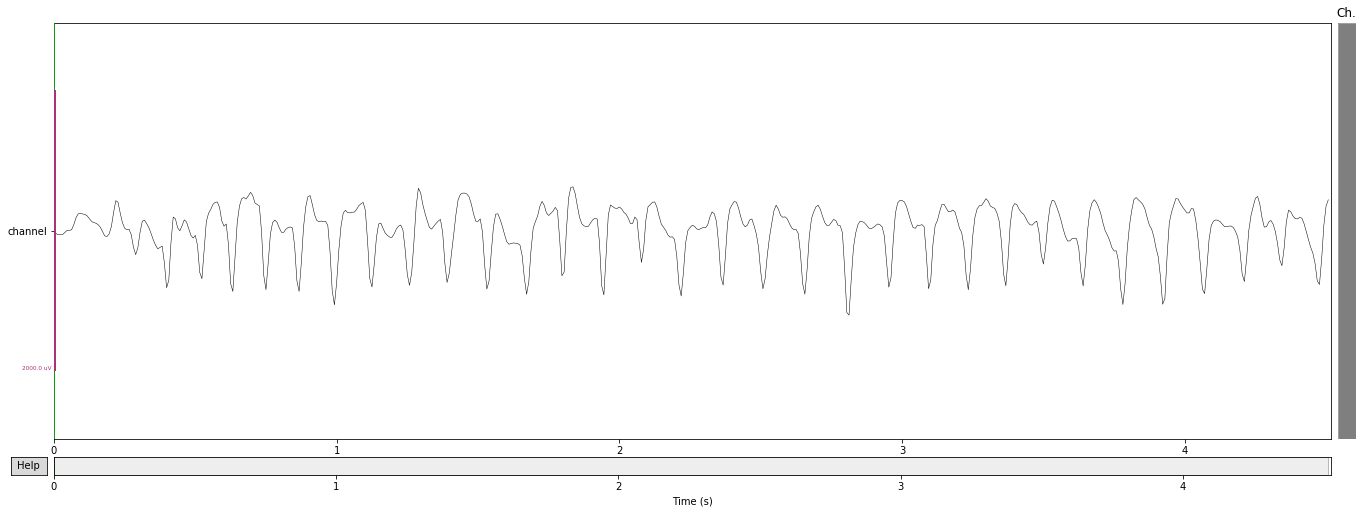

no signifncant values found


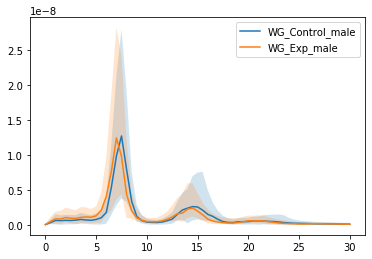

In [73]:
control_name = 'WG_Control_male'
exp_name = 'WG_Exp_male'

x, welch_control_m=welch_spectrum_all_rats(iter_pickle(data_path/control_name), normalize=False)
x, welch_exp_m=welch_spectrum_all_rats(iter_pickle(data_path/exp_name), normalize=False)

spectrums = {'x':x, 'spectrums':{control_name:welch_control_m, exp_name:welch_exp_m}}
spectrums['significance'] = statistics_nonparametric(spectrums, correction=True)
plot_conditions(spectrums)

no signifncant values found


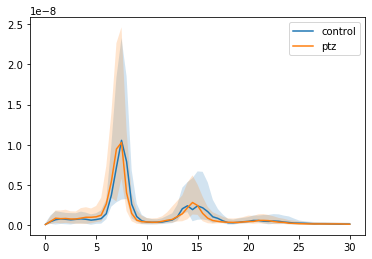

In [87]:
spectrums = {'x':x, 'spectrums':{'control':np.r_[welch_control_m,welch_control_f], 'ptz':np.r_[welch_exp_m,welch_exp_f]}}
spectrums['significance'] = statistics_nonparametric(spectrums, correction=True)
plot_conditions(spectrums)
